In [26]:
import pandas as pd
import h5py

import pandas as pd

# Read the integrated_train_data.csv file
dataset = pd.read_csv('/Users/yunbo/Documents/GitHub/PFL_Optimiozation/FL_Clustering/integrated_train_data_ISMM.csv')

# Get unique market values
markets = dataset['index'].unique()

# Create a dictionary to map regions to numbers
region_mapping = {region: i for i, region in enumerate(markets)}

# Add a new column 'Region Index' to represent the regions with numbers
dataset['Region Index'] = dataset['index'].map(region_mapping)

dataset = dataset.drop(columns=['index'])

# Print the modified dataset
print(dataset)
print(region_mapping)

# Get unique market values
markets = dataset['Region Index'].unique()

print(markets)

#
with h5py.File('market_data_original.h5', 'w') as f:
    for market in markets:
        market_str = str(market)
        market_data = dataset[dataset['Region Index'] == market]
        print(market_str)
        print(market_data)
        # Store the data as a dataset
        f.create_dataset(market_str, data=market_data.to_numpy())
        # Store the column names as an attribute
        f[market_str].attrs['columns'] = market_data.columns.tolist()

        Order Id  Order Customer Id  Order Item Id  Order Item Product Price  \
0          77202              20755         180517                327.750000   
1          75939              19492         179254                327.750000   
2          75938              19491         179253                327.750000   
3          75937              19490         179252                327.750000   
4          75936              19489         179251                327.750000   
...          ...                ...            ...                       ...   
180514     26043               1005          65177                399.980011   
180515     26037               9141          65161                399.980011   
180516     26024                291          65129                399.980011   
180517     26022               2813          65126                399.980011   
180518     26018               7547          65113                399.980011   

        Department Id  Category Id  shi

           0        1         2           3    4     5    6           7   \
0     77202.0  20755.0  180517.0  327.750000  2.0  73.0  2.0   91.250000   
1     75929.0  19482.0  179244.0  327.750000  2.0  73.0  1.0   45.689999   
2     75928.0  19481.0  179243.0  327.750000  2.0  73.0  1.0   21.760000   
3     75905.0  19458.0  179220.0  327.750000  2.0  73.0  1.0  152.600006   
4     75900.0  19453.0  179215.0  327.750000  2.0  73.0  1.0  143.160004   
...       ...      ...       ...         ...  ...   ...  ...         ...   
9534  26165.0   6024.0   65495.0  399.980011  7.0  45.0  1.0  133.839996   
9535  26130.0   5187.0   65409.0  399.980011  7.0  45.0  1.0  130.490005   
9536  26087.0   2642.0   65296.0  399.980011  7.0  45.0  1.0 -337.100006   
9537  26083.0   1238.0   65285.0  399.980011  7.0  45.0  1.0 -258.779999   
9538  26059.0   8247.0   65219.0  399.980011  7.0  45.0  1.0   50.110001   

          8     9   ...      17         18   19   20      21   22   23  \
0     1360.0 

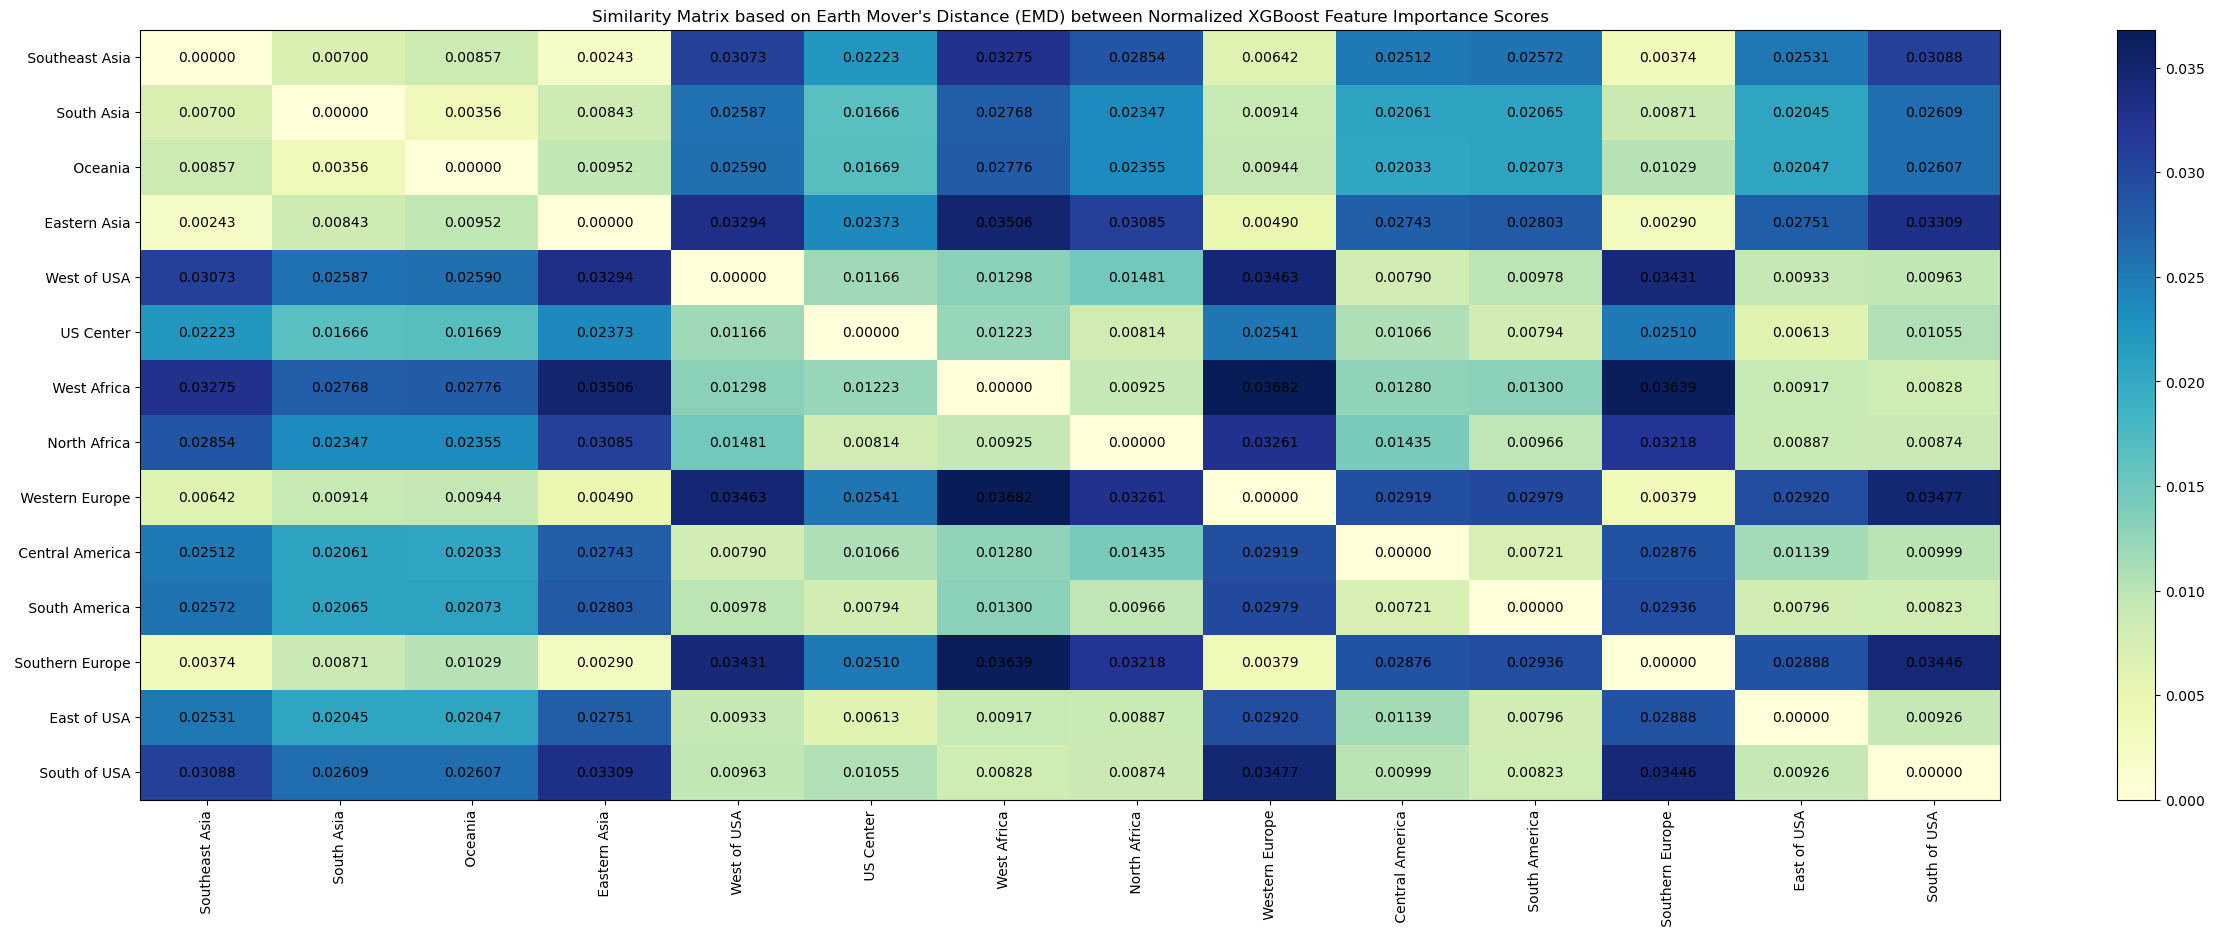

In [27]:
import pandas as pd
import networkx as nx
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from grakel.kernels import GraphletSampling
from grakel.utils import graph_from_networkx
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

# Step i: Reading Data and XGBoost Feature Importance

# Open the HDF5 file
file = h5py.File("market_data_original.h5", "r")

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']

# Initialize an empty list to store DataFrames from each sheet
dataframes = []

# Read and concatenate DataFrames from each sheet
for sheet_name in sheet_names:
    # Read the dataset using the current sheet name
    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)

    print(dataset)

    # Read the column names from the attributes
    column_names = file[sheet_name].attrs["columns"]

    # Assign column names to the dataset
    dataset.columns = column_names

    # Append the DataFrame to the list
    dataframes.append(dataset)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Replace "Region Index" with "Order Region"
df.rename(columns={"Region Index": "Order Region"}, inplace=True)

# Replace numbers with corresponding names using region_map
df["Order Region"] = df["Order Region"].map(region_map)


# Function to calculate EMD between two distributions
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# List to store XGBoost feature importance scores for each region
feature_importance_scores = []
# Copy the original DataFrame to avoid modifying the original data
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    # Store feature importance scores
    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))


# Reverse the label encoding to get the original region names
reverse_mapping = {v: k for k, v in region_map.items()}
# List to store region names
region_names = []
# Create t-SNE projections and store region names
# Create t-SNE projections and store region names
for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))




# Function to normalize feature importance scores
def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(normalized_feature_importance[i], normalized_feature_importance[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

# Plot the similarity matrix
plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

# Add text annotations for each grid
for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()



In [28]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate pairwise EMD distances
emd_distances = pairwise_distances(normalized_feature_importance, metric=calculate_emd)

# Perform clustering using KMeans with EMD distances
num_clusters = 3  # Set the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(emd_distances)

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 2
Region:  Eastern Asia, Cluster: 1
Region:  West of USA, Cluster: 0
Region:  US Center, Cluster: 0
Region:  West Africa, Cluster: 0
Region:  North Africa, Cluster: 0
Region:  Western Europe, Cluster: 1
Region:  Central America, Cluster: 0
Region:  South America, Cluster: 0
Region:  Southern Europe, Cluster: 1
Region:  East of USA, Cluster: 0
Region:  South of USA, Cluster: 0
